# Community Detection Algorithms

Community formation is common in all types of networks, and identifying them is essential for evaluating group behavior and emergent phenomena. The general principle in finding communities is that its members will have more relationships within the group than with nodes outside their group. Identifying these related sets reveals clusters of nodes, isolated groups, and network structure. This information helps infer similar behavior or preferences of peer groups, estimate resiliency, and etc.

1. <b>Triangle count and clustering coefficient</b>: Measures how many nodes from triangles and the degree to which nodes tend to cluster together. 
2. <b>Strongly connected components</b>: Find groups where each node is reachable from every other node in that same group following the direction of relationships. 
3. <b>Connected components</b>: Find groups where each node is reachable from every other node in that same group regardless of the direction of relationships. 
4. <b>Label propagation</b>: Infers clusters by spreading labels based on neighborhood majorities.
5. <b>Louvain modularity</b>: Maximizes the presumed accuracy of groupings by comparing relationships weights and densities to a defined estimate or average. 

## Create Graph

In [1]:
# Import libraries
import pandas as pd
from neo4j import GraphDatabase

In [2]:
# connect to neo4j server
user = "neo4j"
password = "xxx"  # change your own password
driver = GraphDatabase.driver("bolt://localhost:7687", auth=(user, password))

In [3]:
# load the csv files of the software dependency graph (sw-nodes and sw-relationships)
with driver.session() as session:
    session.run("""
    LOAD CSV WITH HEADERS FROM "file:///data/sw-nodes.csv" AS row
    MERGE (:Library {id:row.id})
    """)
    
    session.run("""
    LOAD CSV WITH HEADERS FROM "file:///data/sw-relationships.csv" AS row
    MATCH (source:Library {id: row.src})
    MATCH (destination:Library {id: row.dst})
    MERGE (source)-[:DEPENDS_ON]->(destination)
    """)

In [4]:
# create in-memory graph, the orientation has to be undirected to use the triangle count algorithm
create_memory_graph_query = """
CALL gds.graph.create(
    'sw',
    ['Library'],
    {
      DEPENDS_ON: {
      orientation: 'UNDIRECTED'
    }}
)
"""

In [5]:
with driver.session() as session:
    session.run(create_memory_graph_query)

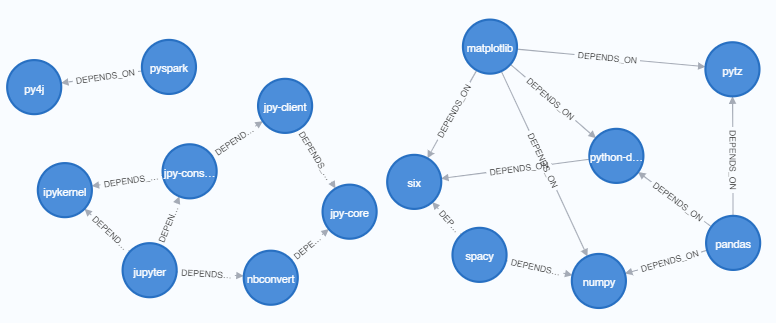

## Triangle Count

Triangle Count determines the number of triangles passing through each node in the graph. A triangle is a set of three nodes,where each node has a relationship to all other nodes.

In [14]:
tri_count_query = """
    CALL gds.alpha.triangles('sw')
    YIELD nodeA, nodeB, nodeC
    RETURN
      gds.util.asNode(nodeA).id AS nodeA,
      gds.util.asNode(nodeB).id AS nodeB,
      gds.util.asNode(nodeC).id AS nodeC
"""

In [15]:
with driver.session() as session:
    rows = session.run(tri_count_query)
    tri_count_df = pd.DataFrame([dict(record) for record in rows])

In [16]:
tri_count_df

,nodeA,nodeB,nodeC
0,jpy-console,jupyter,ipykernel
1,six,python-dateutil,matplotlib


From the created software dependency graph, we can see that there's two triangle formed, which are "jpy-console, jupyter, ipykernel" and "six, python-dateutil, matplotlib". 

## Local Clustering Coefficient

The Clustering Coefficient algorithm measures how tightly a group is clustered compared to how tightly it could be clustered. The algorithm uses Triangle Count in its calculations, which provides a ratio of existing triangles to possible relationships.

In [22]:
clus_coeff_query = """
    CALL gds.localClusteringCoefficient.stream('sw')
    YIELD nodeId, localClusteringCoefficient
    WHERE localClusteringCoefficient > 0
    RETURN gds.util.asNode(nodeId).id AS library, localClusteringCoefficient
    ORDER BY localClusteringCoefficient DESC
"""

In [23]:
with driver.session() as session:
    rows = session.run(clus_coeff_query)
    clus_coeff_df = pd.DataFrame([dict(record) for record in rows])

In [24]:
clus_coeff_df

,library,localClusteringCoefficient
0,ipykernel,1.000000
1,jpy-console,0.333333
2,six,0.333333
3,python-dateutil,0.333333
4,jupyter,0.333333
5,matplotlib,0.166667


 ipykernel has a score of 1, which means that all ipykernel’s neighbors are neighbors of each other. This tells us that the community directly around the ipykernel is very cohesive.

## Strongly Connected Components

The Strongly Connected Components (SCC) algorithm is one of the earliest graph algorithms. SCC finds sets of connected nodes in a directed graph where each node is reachable in both directions but not necessarily directly from any other node in the same set.

In [28]:
scc_query = """
    CALL gds.alpha.scc.stream({
      nodeProjection: 'Library',
      relationshipProjection: 'DEPENDS_ON'
    })
    YIELD nodeId, componentId
    RETURN gds.util.asNode(nodeId).id AS library, componentId AS component
    ORDER BY component DESC
"""

In [29]:
with driver.session() as session:
    rows = session.run(scc_query)
    scc_df = pd.DataFrame([dict(record) for record in rows])

In [30]:
scc_df

,library,component
0,jpy-core,14
1,jpy-client,13
2,ipykernel,12
3,jupyter,11
4,py4j,10
5,spacy,9
6,matplotlib,8
7,pyspark,7
8,pytz,6
9,python-dateutil,5


Every node is in its own partition. 

## Weakly Connected Components

The Connected Components algorithm (sometimes called Union Find or Weakly Connected Components) finds sets of connected nodes in an undirected graph where each node is reachable from any other node in the same set.

Connected Components is often used early in an analysis to understand a graph's structure. It can quickly show new nodes in common between groups. Make it a habit to run Connected Components to test whether a graph is connected as a preparatory step for general graph analysis. 

In [36]:
wcc_query = """
    CALL gds.wcc.stream('sw')
    YIELD nodeId, componentId
    RETURN collect(gds.util.asNode(nodeId).id) AS library, componentId
    ORDER BY componentId, library
"""

In [37]:
with driver.session() as session:
    rows = session.run(wcc_query)
    wcc_df = pd.DataFrame([dict(record) for record in rows])

In [39]:
pd.set_option('max_colwidth', 100)
display(wcc_df)

,library,componentId
0,"[jpy-console, nbconvert, jupyter, ipykernel, jpy-client, jpy-core]",0
1,"[six, pandas, numpy, python-dateutil, pytz, matplotlib, spacy]",2
2,"[pyspark, py4j]",7


There are three components just by visual inspection. 

## Label Propagation

The Label Propagation algorithm (LPA) is a fast algorithm for finding communities in a graph. In LPA, nodes select their group based on their direct neighbors. This process is well suited to networks where groupings are less clear and weights can be used to help a node determine which community to place itself within.

In [40]:
label_prop_query = """
    CALL gds.labelPropagation.stream('sw')
    YIELD nodeId, communityId AS Community
    RETURN collect(gds.util.asNode(nodeId).id) AS Libraries, Community
    ORDER BY size(Libraries) DESC
""" 

In [41]:
with driver.session() as session:
    rows = session.run(label_prop_query)
    label_prop_df = pd.DataFrame([dict(record) for record in rows])

In [42]:
pd.set_option('max_colwidth', 100)
display(label_prop_df)

,Libraries,Community
0,"[six, pandas, numpy, python-dateutil, pytz, matplotlib, spacy]",33
1,"[jpy-console, nbconvert, jupyter, ipykernel, jpy-client, jpy-core]",40
2,"[pyspark, py4j]",39


The Label Propagation algorithm finds three clusters. 

## Louvain Modularity

The Louvain Modularity algorithm finds clusters by comparing community density as it assigns nodes to different groups. You can think of this as a “what if ” analysis to try various groupings with the goal of reaching a global optimum.

In [46]:
louvain_query = """
    CALL gds.louvain.stream('sw')
    YIELD nodeId, communityId, intermediateCommunityIds
    RETURN gds.util.asNode(nodeId).id AS library, communityId, intermediateCommunityIds
    ORDER BY communityId ASC
"""

In [47]:
with driver.session() as session:
    rows = session.run(louvain_query)
    louvain_df = pd.DataFrame([dict(record) for record in rows])

In [48]:
louvain_df

,library,communityId,intermediateCommunityIds
0,six,8,None
1,pandas,8,None
2,numpy,8,None
3,python-dateutil,8,None
4,pytz,8,None
5,matplotlib,8,None
6,spacy,8,None
7,pyspark,10,None
8,py4j,10,None
9,jpy-console,14,None


## Acknowledgement

This jupyter notebook is modified based on the book "Graph Algorithms: Practical Examples in Apache Spark & Neo4j", written by Mark Needham and Amy E. Hodler. 

Note: However, the graph algorithm library used in this book is out to date, the current library used is the Graph Data Science library: https://neo4j.com/docs/graph-data-science/current/algorithms/. Some of the results might be varied from those in the book. 